MNIST è un dataset in scala di grigi, sono cifre da 0 a 9 scritte a mano, hanno dimensione 28x28 con 1 solo layer di profondità (28, 28, 1)

Pytorch le legge come (1, 28, 28)

In [ ]:
import torch
import torch.nn as nn # riguardano la definizione dei layer, funzioni loss...
import torch.nn.functional as F # ci sono le vere e proprie funzioni, per esempio quelle di attivazione
import torch.optim as optim # ottimizzatori e tutto ciò che li riguarda, anche gli scheduler del learning rate
from torchvision import datasets, transforms # importa i dataset (ne hanno tanti basilari che possono essere tranquillamente scaricati) e i transforms che serve per applicare trasformazioni sulle immagini

In [ ]:
class Net(nn.Module): # architettura rete
    def __init__(self): # si definisce una init, sono classi che estendono module di pytorch, classe che estende Module, bisogna mettere init e forward
        # nell'init si definisce la struttura della rete ovvero il numero di layer, è il costruttore della classe, si mettono i parametri
        # nell'init si dichiarano i layer, non è importante metterli in ordine perché l'ordine di esecuzione viene definito nel forward
        # si mettono i layer di cui bisogna definire la strutta, ma non hanno niente a che vedere con la struttura effetiva della rete che invece viene definita nel forward
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None) # dim kernel della convoluzione, il device ci fa andare in GPU, padding va bene 0 in MNIST perchè il background è nero, il foreground è bianco 1
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # ha un canale di ingresso (è =1 perché le immagini MNIST hanno 1 canale), perchè le immagini di mnist hanno un canale, 32 uscite, kernel 3 e stride 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # i canali di ingresso diventano 32 (altrimenti il forward si romperebbe!), aumentiamo gli output, lasciamo così kernel e stride
        # self.dropout = nn.Dropout(p=0.4)
        # self.bn1 = nn.BatchNorm1d(9216) # 1D è sui vettori, 2D è sulle immagini
        # self.bn2 = nn.BatchNorm1d(128) # dal flatten in su si può usare il batchnorm2d, dal flatten in giù si usa batchnorm1d
        # dopo maxpooling facciamo un flatten
        self.fc1 = nn.Linear(9216, 128) # ingresso: dimensione uscita flatten, li mappa a 128 # nb: il bias è impostato su true di default # (3 x 3 x 64 x 32) / 2
        self.fc2 = nn.Linear(128, 10) # da 128 andiamo a 10, sarà l'ingresso della softmax

        # dichiarazione layer lineare: prima posizione: prende in ingresso la dimensione delle features, in seconda posizione prende la dimensione di uscita delle features, e poi c'è il bias

        # qui non ci saranno tutti i layer della rete, si dichiarano solo quelli che hanno bisogno dell'init

    def forward(self, x):
      # si definisce il forward della rete
      # si usano le relu, maxpooling... si chiamano le funzioni, struttura della rete in favore delle funzioni
      # il primo batch che eseguiamo è il più lento, perché la prima volta che fa il forward deve costruire e strutturare la rete
      # viene definito ordine esecuzione layer del modello!
      # questo è importante perchè le dl non usano questa eager-mode ma definiscono la struttura della rete prima dell'inizio del batch
      # qui usiamo la eager-mode, facile per il debug!
      # il maxpooling riduce dimensione immagine, non ne mettiamo molte sennò riduce tantissimo l'immagine!
      # nel pytorch si mette prima RGB e poi dimensione, quindi (batch_size, numero canali, altezza, larghezza)
      # x.shape = Bs, nC, H, W
      # qui si dichiarano gli altri livelli
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.dropout(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # x = self.dropout(x)
        x = torch.flatten(x, 1) # da tensore diventa un vettore (non toccando il batch_size), da 3 dim si va a 2 # da qui in poi, struttura della rete piuttosto fissa
        # x = self.bn1(x)
        x = self.fc1(x)
        y = F.relu(x) # y
        # x = self.dropout(x)
        # x = self.bn2(x)
        y = self.fc2(x) # y per plottare features
        output = F.log_softmax(y, dim=1) # l'output di questa rete sarà una softmax, è un tensore con dim numero_valori_batch x n_classi (es: batch = 64, 64 x 10, somma a 1, è come la probabilità che la rete dà a un input di appartenere a una certa classe) # in uscita abbiamo il log della softmax
        # y qui sopra, nella log_softmax
        return output


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train() # su pytorch ci sono layer che a seconda se è a test o a train cambia comportamento
    # LOOP DI TRAINING, si fa il ciclo sul Loader, su tutto il Dataset
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader): # enumerate perchè ci serve id batch, data sono le immagini (64 immagini - batch - e 64 target), dati che arrivano già trasformati da transform, abbiamo già tensori normalizzati
      # IMPORTANTE CHE SIANO TRASFORMATI A TENSORI
        data, target = data.to(device), target.to(device) # mandiamo dati e label sulla GPU, come la rete! IMPORTANTE!!! ERRORE SE STANNO SU CPU E GPU SEPARATAMENTE
        optimizer.zero_grad() # azzera i gradienti ad ogni loop su train_loader IMPORTANTE! in alcuni contensti non serve, contesti specifici. Deve essere messo prima del backprop, se non li azzeriamo, sommiamo passati + attuali, raramente serve

        # FORWARD
        output = model(data) # output 64 x 10, batch x numero_classi, valori che sommano a 1, perchè in fondo alla rete abbiamo la softmax
        loss = F.nll_loss(output, target) # calcoliamo l'errore, cross entropy loss sulla base output rete e ground truth. è l'errore tra l'uscita rete e ground truth. è tipicamente un tensore che ha come funzioni cosa che possono fare tipo la backprop
        loss.backward() # calcola la derivata dell'uscita rispetto all'inuput del layer, il calcolo della derivata può essere scomposta con le derivate composte, si vanno a calcolare sempre altre due deriate ovvero la derivata di uscita di un layer rispetto all'entrata e la derivata d'uscita rispetto ai pesi del layer
        # PASSO OTTIMIZZATORE
        optimizer.step()

        # FINISCO TRAIN LOADER E RIPETO PER TUTTE LE EPOCHE
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())) # loss.item() restituisce il float dell'errore che stiamo facendo
            losses.append(loss.item())
    return np.mean(losses)

In [ ]:
def test(model, device, test_loader):
    model.eval() # DIFFERENZA! modalità test
    # non c'è nè la backprop nè l'ottimizzazione
    test_loss = 0
    correct = 0
    with torch.no_grad(): # tutto il calcolo dentro la funzione di test noi vogliamo EVITARE di calcolare il gradiente, così non lo calcoliamo, calcoli più veloci, solo FORWRD!
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss, calcoliamo errore di test
            # CALCOLO DELL'ACCURATEZZA
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability, per ogni vettore nel batch prendo l'argmax, prendo la classe predetta dalla rete per l'immagine, pred tensore 64 elementi, 1 (id classe predetta)
            correct += pred.eq(target.view_as(pred)).sum().item() # calcola accuratezza modello, si somma quante volte il target è uguale alla mia predizione

    test_loss /= len(test_loader.dataset) # errori test / quante volte ci ho preso

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
import numpy as np

device = torch.device("cuda") # to use the GPU # main, vogliamo usare GPU
batch_size = 64 #iperparametro
epochs = 10 # iperparametro
lr = 0.001 # 0.1

# quando siamo arrivati a convergenza? 1) quando l'errore è prossimo a 0, quando l'errore tra l'uscita e ground truth è circa 0, attenzione all'overfit (se è proprio 0 e non 0,qualcosa)!
# 2) guardare anche accuratezza del modello (non si fa molto... principalmente si guarda la loss)

# una buona scelta del learning rate è fondamentale per la convergenza del modello, cambiarlo NEL REPORT: COSA SUCCEDE CON UN LR ALTO, BASSO E CORRETTO?

# BLOCCO DEI DATI

transform=transforms.Compose([
        # qui verranno applicate le trasformazioni che modificano le immagini, DATA AUGMENTATION, vengono fatte PRIMA della trasformazione in tensore
        transforms.ToTensor(), # trasformazione, converte un'immagine in un tensore e scala i valori in maniera corretta (perché tutte le reti processano float32, siccome le immagini sono spesso int, questa trasformazione fa un cast da int a float) # a volte per velocizzare si usa una libreria per usare float16 per velocizzare il forward
        # da H x W x C si va a C x H x W
        transforms.Normalize((0.1307,), (0.3081,)) # trasforma i RGB da 0 a 255 in un range da 0 a 1, è bene che siano così per il processo di elaborazione della rete, evitano l'exploding gradient # questi numeri sono la media e la standard deviation calcolati sul dataset
        # se voglio trovarli a mano, devo calcolare media e sd su tutto il dataset
      ])
# posso definire una lista di trasformazioni ogni qual volta che faccio un processo di estrazione dei dati dal dataset
# normalizzo i valori per avere dati più uniformi

# spesso le trasformazioni sono diverse per train e test

dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform) # scarico il ds, dove scaricarlo, se è di train (prendo lo split che riguarda il train) e che trasform uso
dataset2 = datasets.MNIST('../data', train=False, transform=transform) # (se metto train = FALSE prendo lo split di test)
# alcune trasformazioni sono obbligatorie per processare l'immagine, perché sono array di interi

# DATALOADER
# crea un iteratore sul ds, specifica come andiamo a estrarre i dati dal ds, per es definiamo grandezza batch
# il DataLoader andrà a prendere dal Ds tot elementi (batch)
# estraggo un batch dal mio loader
# i DataLoader sono degli iteratori sul dataset, vanno a chiamare all'interno della classe Dataset la funzione getDataset(), pesco i dati dal Dataset
train_loader = torch.utils.data.DataLoader(dataset1, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size) # dati presi randomicamente, sul trainloader E' OBBLIGATORIO, n_worker = quanti thread per estrarre dati (in Dataset piccini va bene 1, in Dataset complessi se ne mettono di più), pin_memory = come velgono salvati i dati in GPU (?)
# c'è un valore chiamato drop_last, ogni batch ha 64, se drop_last = FALSE l'ultimo batch può avere una dimensione diversa da 64 (se i nostri elementi non è divisibile per 64, rimangono fuori dei valori), dipende dai contesti applicativi
# di base è su FALSE
# drop_last = TRUE tutti stessa dimensione, è bene fare step ottimizzazione con un numero di elementi ben stabilito, TRUE SU TRAIN E FALSE SU TEST
test_loader = torch.utils.data.DataLoader(dataset2, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size) # nel test non è obbligatorio # non è obbligatorio nemmeno fare lo shuffle

model = Net().to(device) # istanzio oggetto di classe e lo alloco in GPU (device cuda)

optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9) # qui weightdecay # definiziamo l'optimizer, usiamo SGD, in ingresso vuole i parametri da ottimizzare (passo model.parameters() che mi dà tutti i parametri, a volte li dobbiamo filtrare se non li vogliamo tutti)
# il secondo parametro è il LEARNING RATE, valore di default 0.1, ma non è ottimale per MNIST, di solito se ne usa uno più basso, perché sennò sarebbe troppo semplice apprendere
# il momentum è a 0, basta mettere ", momentum = 0.9" CAMBIARE!!! 1 NO perchè se momentum = 1 sto fermo, quindi non si mette, NON SI AGGIORNA!! tipicamente è tra 0 e 9, 0.99
# un momentum alto è importante quando il batch_size è molto piccolo, in questo modo limitiamo il gradiente a un certo momento, ma diamo peso a tutto il dataset


#optimizer = optim.AdamW(model.parameters(), lr = lr)


#for epoch in range(1, epochs + 1):
    # EPOCA
    # due step: train e test
    # sarebbe stato meglio usare il validation set e il test usarlo a fine
    #train(model, device, train_loader, optimizer, epoch)
    #test(model, device, test_loader)


train_losses = []
test_losses = []
test_accuracies =[]

best_acc = 0

for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, device, test_loader)
    #if test

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311726
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.507452

Test set: Average loss: 0.2338, Accuracy: 9313/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.118038
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.153211

Test set: Average loss: 0.1242, Accuracy: 9667/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.106938
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.195372

Test set: Average loss: 0.0842, Accuracy: 9757/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.021335
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.082361

Test set: Average loss: 0.0663, Accuracy: 9798/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.113996
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.035617

Test set: Average loss: 0.0574, Accuracy: 9825/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.031735
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.091675

Test set: Average loss: 0.0568, Accuracy: 9816/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.097679
Train Epoch: 7 [320

**SGD lr = 0.001**

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310383
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.755164

Test set: Average loss: 0.4351, Accuracy: 8841/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.437150
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.308991

Test set: Average loss: 0.3336, Accuracy: 9034/10000 (90%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.272750
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.449546

Test set: Average loss: 0.3087, Accuracy: 9105/10000 (91%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.322619
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.426755

Test set: Average loss: 0.2932, Accuracy: 9167/10000 (92%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.241295
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.243182

Test set: Average loss: 0.2855, Accuracy: 9184/10000 (92%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.270395
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.234094

Test set: Average loss: 0.2759, Accuracy: 9216/10000 (92%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.205451
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.236250

Test set: Average loss: 0.2636, Accuracy: 9237/10000 (92%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.319049
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.201534

Test set: Average loss: 0.2574, Accuracy: 9267/10000 (93%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.559297
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.431375

Test set: Average loss: 0.2457, Accuracy: 9288/10000 (93%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.267279
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.256120

Test set: Average loss: 0.2320, Accuracy: 9314/10000 (93%)

In [ ]:
print(model)
# fa vedere i livelli dichiarati in init


In [ ]:
print(dataset1) # dati di training

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [ ]:
print(dataset2) # dati di test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [ ]:
print(dataset1.data.shape)

In [ ]:
print(dataset1.data[0]) # primo elemento

In [ ]:
print(dataset1.data[0].shape) # stampa dimensione primo elemento

In [ ]:
print([f for f in train_loader][0]) # costruisco lista per batch (64) e prendo il primo elemento del train_loader NB non c'è corrispondeza tra primo elemento dataset1 e train_loader perché lo shuffle è a True

##Exercise 0
Create a plot of the values of the training losses and training accuracies (e dei test).

This can help to monitor how the training is going.

In [ ]:
# salvarli valori loss e accuratezza nel train e nel test, per non prenderle tutte si fa la media dell'epoca (a volte è importante tenersi anche le loss calcolati per ogni iterazione)
# dopo non si rialza il test ...
# overfit: 100% accuratezza train set, ma accuracy bassissima su test
import matplotlib.pyplot as plt

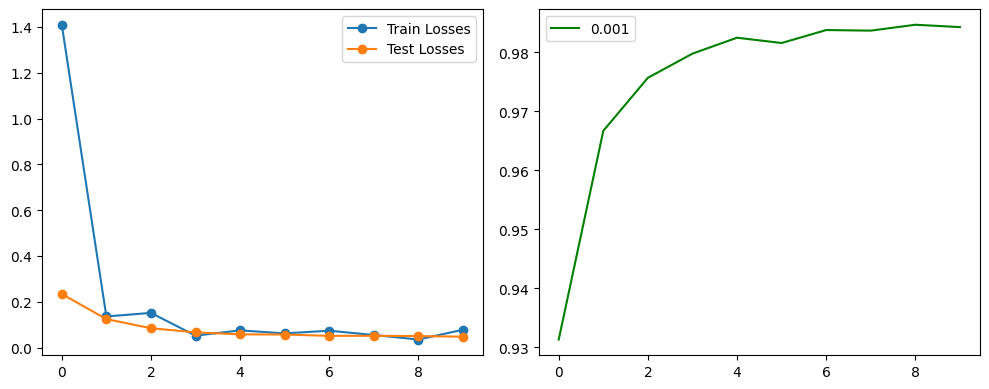

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Creazione della figura e degli assi
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 riga, 2 colonne

# Plot del primo grafico
plt1.plot(train_losses, '-o', label = 'Train Losses')
plt1.plot(test_losses, '-o', label = 'Test Losses')
plt1.legend()


# Plot del secondo grafico
plt.plot(test_accuracies, label = lr, color = 'green')
plt.legend()


# Regolazione del layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra i grafici
plt.show()

# Rete con 3 Layer di Dropout (p=0.4)

## Exercise 1

Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding)

How the performance change? Why?

Cambiare architettua della rete e vedere cosa succede alle performance, e/o gli iperparametri della rete, per ora lasciare invariati parametri di training, rivedere anche i plot (non cambiare per esempio il kernel della CNN e il lr, perché fare due cambi così diversi non ci permette di capire cosa fa cambiare le performance)

mettere dropout e batch normalization

[NOME]: stride = 2 e tolto maxpool, più o meno uguale, accuracy 99 epoche 10

quando si va a complicare il training, servono più epoche per arrivare allo stesso punto di accuracy/loss

weigh_decay?

In [ ]:
class Net(nn.Module): # architettura rete
    def __init__(self): # si definisce una init, sono classi che estendono module di pytorch, classe che estende Module, bisogna mettere init e forward
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # ha un canale di ingresso (è =1 perché le immagini MNIST hanno 1 canale), perchè le immagini di mnist hanno un canale, 32 uscite, kernel 3 e stride 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # i canali di ingresso diventano 32 (altrimenti il forward si romperebbe!), aumentiamo gli output, lasciamo così kernel e stride
        self.dropout = nn.Dropout(p=0.4)
        # self.bn1 = nn.BatchNorm1d(9216) # 1D è sui vettori, 2D è sulle immagini
        # self.bn2 = nn.BatchNorm1d(128) #dal flatten in su si può usare il batchnorm2d, dal flatten in giù si usa batchnorm1d
        # dopo maxpooling facciamo un flatten
        self.fc1 = nn.Linear(9216, 128) # ingresso: dimensione uscita flatten, li mappa a 128 # nb: il bias è impostato su true di default # (3 x 3 x 64 x 32) / 2
        self.fc2 = nn.Linear(128, 10) # da 128 andiamo a 10, sarà l'ingresso della softmax

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1) # da tensore diventa un vettore (non toccando il batch_size), da 3 dim si va a 2 # da qui in poi, struttura della rete piuttosto fissa
        # x = self.bn1(x)
        x = self.fc1(x)
        y = F.relu(x) # y
        x = self.dropout(x)
        # x = self.bn2(x)
        y = self.fc2(x) # y per plottare features
        output = F.log_softmax(y, dim=1) # l'output di questa rete sarà una softmax, è un tensore con dim numero_valori_batch x n_classi (es: batch = 64, 64 x 10, somma a 1, è come la probabilità che la rete dà a un input di appartenere a una certa classe) # in uscita abbiamo il log della softmax
        # y qui sopra, nella log_softmax
        return output

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())) # loss.item() restituisce il float dell'errore che stiamo facendo
            losses.append(loss.item())
    return np.mean(losses)

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) # errori test / quante volte ci ho preso

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
device = torch.device("cuda") # to use the GPU # main, vogliamo usare GPU
batch_size = 64 #iperparametro
epochs = 10 # iperparametro
lr = 0.001 # 0.1

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
#optimizer = optim.AdamW(model.parameters(), lr = lr)


train_losses = []
test_losses = []
test_accuracies =[]


for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, device, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326155
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.663470

Test set: Average loss: 0.2602, Accuracy: 9296/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.221610
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.306727

Test set: Average loss: 0.1369, Accuracy: 9638/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.248048
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.155895

Test set: Average loss: 0.1025, Accuracy: 9713/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.151760
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.184631

Test set: Average loss: 0.0825, Accuracy: 9777/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.152696
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.085729

Test set: Average loss: 0.0676, Accuracy: 9809/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.101908
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.146510

Test set: Average loss: 0.0641, Accuracy: 9810/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.055702
Train Epoch: 7 [320

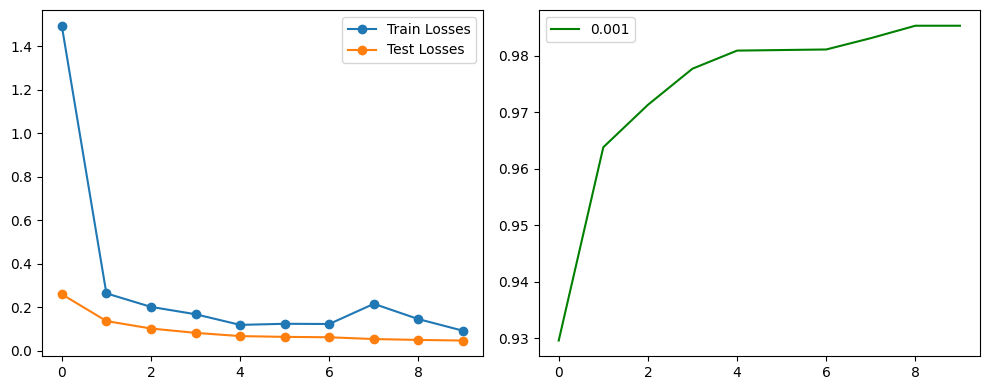

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 riga, 2 colonne

# primo grafico
plt1.plot(train_losses, '-o', label = 'Train Losses')
plt1.plot(test_losses, '-o', label = 'Test Losses')
plt1.legend()


# secondo grafico
plt.plot(test_accuracies, label = lr, color = 'green')
plt.legend()


plt.tight_layout()
plt.show()

# Rete con 2 Layer di Batch Normalization 1D

In [ ]:
class Net(nn.Module): # architettura rete
    def __init__(self): # si definisce una init, sono classi che estendono module di pytorch, classe che estende Module, bisogna mettere init e forward
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # ha un canale di ingresso (è =1 perché le immagini MNIST hanno 1 canale), perchè le immagini di mnist hanno un canale, 32 uscite, kernel 3 e stride 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # i canali di ingresso diventano 32 (altrimenti il forward si romperebbe!), aumentiamo gli output, lasciamo così kernel e stride
        self.bn1 = nn.BatchNorm1d(9216) # 1D è sui vettori, 2D è sulle immagini
        self.bn2 = nn.BatchNorm1d(128) #dal flatten in su si può usare il batchnorm2d, dal flatten in giù si usa batchnorm1d
        # dopo maxpooling facciamo un flatten
        self.fc1 = nn.Linear(9216, 128) # ingresso: dimensione uscita flatten, li mappa a 128 # nb: il bias è impostato su true di default # (3 x 3 x 64 x 32) / 2
        self.fc2 = nn.Linear(128, 10) # da 128 andiamo a 10, sarà l'ingresso della softmax

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1) # da tensore diventa un vettore (non toccando il batch_size), da 3 dim si va a 2 # da qui in poi, struttura della rete piuttosto fissa
        x = self.bn1(x)
        x = self.fc1(x)
        y = F.relu(x) # y

        x = self.bn2(x)
        y = self.fc2(x) # y per plottare features
        output = F.log_softmax(y, dim=1) # l'output di questa rete sarà una softmax, è un tensore con dim numero_valori_batch x n_classi (es: batch = 64, 64 x 10, somma a 1, è come la probabilità che la rete dà a un input di appartenere a una certa classe) # in uscita abbiamo il log della softmax
        # y qui sopra, nella log_softmax
        return output

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())) # loss.item() restituisce il float dell'errore che stiamo facendo
            losses.append(loss.item())
    return np.mean(losses)

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) # errori test / quante volte ci ho preso

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
device = torch.device("cuda") # to use the GPU # main, vogliamo usare GPU
batch_size = 64 #iperparametro
epochs = 10 # iperparametro
lr = 0.001 # 0.1

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
#optimizer = optim.AdamW(model.parameters(), lr = lr)

train_losses = []
test_losses = []
test_accuracies =[]


for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, device, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.423983
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.119615

Test set: Average loss: 0.0672, Accuracy: 9836/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.061147
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.067748

Test set: Average loss: 0.0508, Accuracy: 9855/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.039007
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.040210

Test set: Average loss: 0.0465, Accuracy: 9868/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.009558
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.029713

Test set: Average loss: 0.0429, Accuracy: 9879/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.024661
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.020045

Test set: Average loss: 0.0405, Accuracy: 9878/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.012486
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.018475

Test set: Average loss: 0.0397, Accuracy: 9873/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.009336
Train Epoch: 7 [320

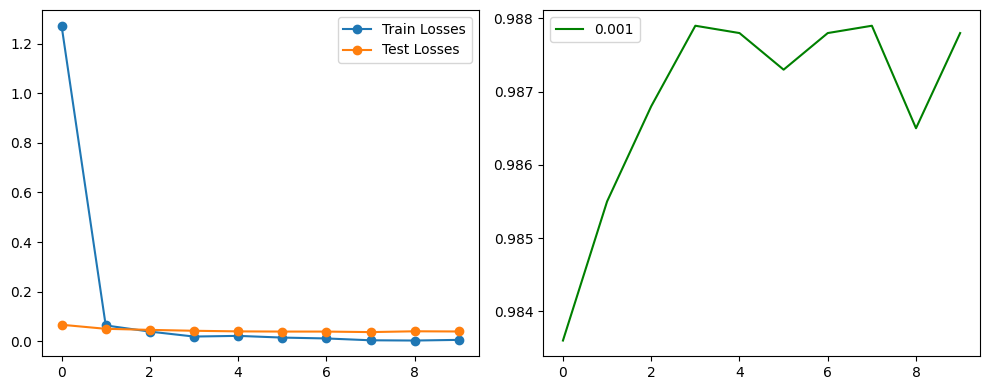

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 riga, 2 colonne

# primo grafico
plt1.plot(train_losses, '-o', label = 'Train Losses')
plt1.plot(test_losses, '-o', label = 'Test Losses')
plt1.legend()


# secondo grafico
plt.plot(test_accuracies, label = lr, color = 'green')
plt.legend()



plt.tight_layout()
plt.show()

# Stride = 2 No MaxPool2D

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 2)
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        y = F.relu(x)

        y = self.fc2(x)
        output = F.log_softmax(y, dim=1) # l'output di questa rete sarà una softmax, è un tensore con dim numero_valori_batch x n_classi (es: batch = 64, 64 x 10, somma a 1, è come la probabilità che la rete dà a un input di appartenere a una certa classe) # in uscita abbiamo il log della softmax
        # y qui sopra, nella log_softmax
        return output

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())) # loss.item() restituisce il float dell'errore che stiamo facendo
            losses.append(loss.item())
    return np.mean(losses)

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) # errori test / quante volte ci ho preso

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
device = torch.device("cuda") # to use the GPU # main, vogliamo usare GPU
batch_size = 64 #iperparametro
epochs = 10 # iperparametro
lr = 0.001 # 0.1

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
#optimizer = optim.AdamW(model.parameters(), lr = lr)

train_losses = []
test_losses = []
test_accuracies =[]


for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, device, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310757
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.287043

Test set: Average loss: 0.3147, Accuracy: 9093/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.633412
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.179113

Test set: Average loss: 0.2380, Accuracy: 9327/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.228007
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.269306

Test set: Average loss: 0.1782, Accuracy: 9516/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.347916
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.092286

Test set: Average loss: 0.1385, Accuracy: 9602/10000 (96%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.139647
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.125954

Test set: Average loss: 0.1046, Accuracy: 9695/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.127864
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.116745

Test set: Average loss: 0.0877, Accuracy: 9721/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.039067
Train Epoch: 7 [320

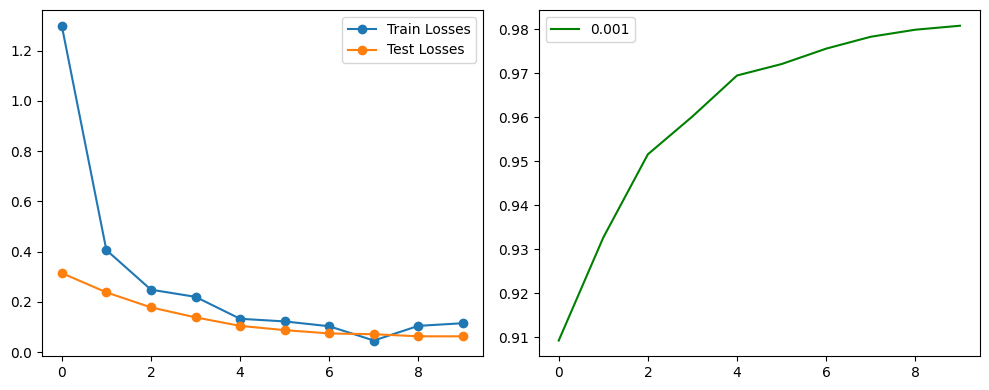

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 riga, 2 colonne

# primo grafico
plt1.plot(train_losses, '-o', label = 'Train Losses')
plt1.plot(test_losses, '-o', label = 'Test Losses')
plt1.legend()


# secondo grafico
plt.plot(test_accuracies, label = lr, color = 'green')
plt.legend()


plt.tight_layout()
plt.show()

# Rete con Kernel 5x5

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)

        self.fc1 = nn.Linear(6400, 128) # ingresso: dimensione uscita flatten, li mappa a 128 # nb: il bias è impostato su true di default # (3 x 3 x 64 x 32) / 2
        self.fc2 = nn.Linear(128, 10) # da 128 andiamo a 10, sarà l'ingresso della softmax



    def forward(self, x):
        x = self.conv1(x) # 24
        x = F.relu(x)

        x = self.conv2(x) # 20
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 10

        x = torch.flatten(x, 1)  # 64 x10x10

        x = self.fc1(x)
        y = F.relu(x)

        y = self.fc2(x)
        output = F.log_softmax(y, dim=1) # l'output di questa rete sarà una softmax, è un tensore con dim numero_valori_batch x n_classi (es: batch = 64, 64 x 10, somma a 1, è come la probabilità che la rete dà a un input di appartenere a una certa classe) # in uscita abbiamo il log della softmax
        # y qui sopra, nella log_softmax
        return output


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())) # loss.item() restituisce il float dell'errore che stiamo facendo
            losses.append(loss.item())
    return np.mean(losses)

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) # errori test / quante volte ci ho preso

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
device = torch.device("cuda") # to use the GPU # main, vogliamo usare GPU
batch_size = 64 #iperparametro
epochs = 10 # iperparametro
lr = 0.001 # 0.1

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
#optimizer = optim.AdamW(model.parameters(), lr = lr)

train_losses = []
test_losses = []
test_accuracies =[]


for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, device, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307014
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.199578

Test set: Average loss: 0.1392, Accuracy: 9561/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.093624
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.069624

Test set: Average loss: 0.0845, Accuracy: 9739/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.075706
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.026465

Test set: Average loss: 0.0631, Accuracy: 9788/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.022388
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.058537

Test set: Average loss: 0.0498, Accuracy: 9844/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.036853
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.114314

Test set: Average loss: 0.0467, Accuracy: 9843/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.007214
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.037420

Test set: Average loss: 0.0424, Accuracy: 9857/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.125670
Train Epoch: 7 [320

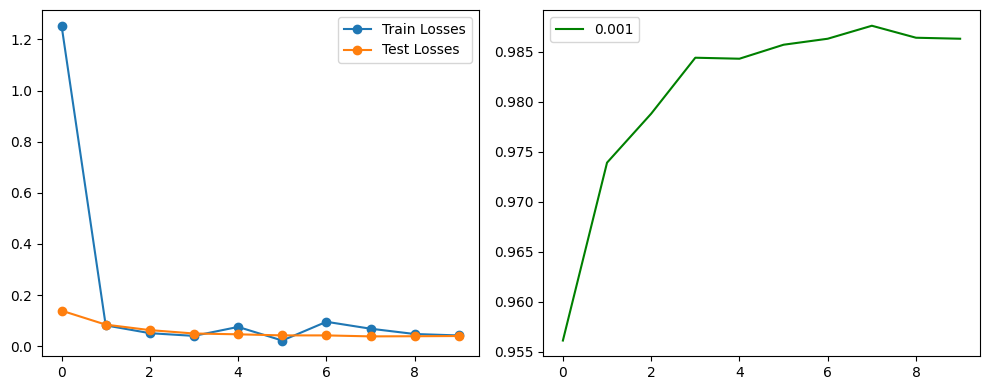

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 riga, 2 colonne

# primo grafico
plt1.plot(train_losses, '-o', label = 'Train Losses')
plt1.plot(test_losses, '-o', label = 'Test Losses')
plt1.legend()


# secondo grafico
plt.plot(test_accuracies, label = lr, color = 'green')
plt.legend()



plt.tight_layout()
plt.show()

## Exercise 2

Try to work with the hyperparameters (batch_size, learning_rate, ...).

In particular try to focus on the optimization part. Change algorithm, momentum, parameters...

How can it be improved?

cercare torch.optim (msprop, adam, adamw), cambiare ottimizzatore

nn.BatchNorm

In [ ]:
# 0.01 0.001 0.001
# con momentum 0.9, senza momentum
# b_64 e b_128
# provare msprop, adam, adamw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        y = F.relu(x)
        y = self.fc2(x)
        output = F.log_softmax(y, dim=1)
        return output